Enexis, Liander, and Stedin are the three major network administrators of the Netherlands and, together, they provide energy to nearly the entire country. Every year, they release on their websites a table with the energy consumption of the areas under their administration.

The data are anonymized by aggregating the Zipcodes so that every entry describes at least 10 connections.

This market is not competitive, meaning that the zones are assigned. This means that every year they roughly provide energy to the same zipcodes. Small changes can happen from year to year either for a change of management or for a different aggregation of zipcodes.

This kernel aims to explore and spark some ideas on how to use this new dataset. 

In drafting it, I was able to spot a few issues in the dataset and correct them. However, the data are coming from different companies and cover several years: assume that there will be inconsistencies for a while.

In [56]:
import numpy as np
import pandas as pd

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from os.path import join, isfile
from os import path, scandir, listdir

import gc

In [57]:
def list_all_files(location='../input/', pattern=None, recursive=True):
    """
    This function returns a list of files at a given location (including subfolders)
    
    - location: path to the directory to be searched
    - pattern: part of the file name to be searched (ex. pattern='.csv' would return all the csv files)
    - recursive: boolean, if True the function calls itself for every subdirectory it finds
    """
    subdirectories= [f.path for f in scandir(location) if f.is_dir()]
    files = [join(location, f) for f in listdir(location) if isfile(join(location, f))]
    if recursive:
        for directory in subdirectories:
            files.extend(list_all_files(directory))
    if pattern:
        files = [f for f in files if pattern in f]
    return files

The data are structured as follows

In [58]:
list_all_files('cleaned_data/Electricity/', pattern='stedin')

['cleaned_data/Electricity/stedin_electricity_2018.csv',
 'cleaned_data/Electricity/stedin_electricity_2009.csv',
 'cleaned_data/Electricity/stedin_electricity_2019.csv',
 'cleaned_data/Electricity/stedin_electricity_2010.csv',
 'cleaned_data/Electricity/stedin_electricity_2011.csv',
 'cleaned_data/Electricity/stedin_electricity_2014.csv',
 'cleaned_data/Electricity/stedin_electricity_2015.csv',
 'cleaned_data/Electricity/stedin_electricity_2017.csv',
 'cleaned_data/Electricity/stedin_electricity_2016.csv',
 'cleaned_data/Electricity/stedin_electricity_2012.csv',
 'cleaned_data/Electricity/stedin_electricity_2020.csv',
 'cleaned_data/Electricity/stedin_electricity_2013.csv']

Let's thus proceed in importing everything in a convenient structure

In [59]:
def importer(file_list):
    imported = {}
    for file in file_list:
        yr = file.split('_')[-1].split('.')[0]
        if '0101' in yr:
            yr = yr.replace('0101', '')
        name = file.split('/')[-1].split('_')[0]
        # print(name, yr)
        df = pd.read_csv(file)
        # print(df.shape)
        imported[name + '_' + yr] = df
        del df
    return imported

In [60]:
elec_list = list_all_files('cleaned_data/Electricity/')
gas_list = list_all_files('cleaned_data/Gas/')
imp_elec = importer(elec_list)
imp_gas = importer(gas_list)
print('Done!')

Done!


# A first look at the data

In this section, we will try to merge all these files together so that we can have an overview of the energy consumption at a given zip code (or group of zip codes) every year. We will first merge by company and then concatenate the results

There are a few obstacles:
* the zipcodes can be grouped differently every year
* the zipcodes can change from year to year (some of them got redefined during this period)
* not only the annual consumption changes but also the number of connections and other indicators change every year, we have to account for that.

In [27]:
def merge_manager(data_dict):
    all_man = pd.DataFrame()
    n_rows = 0
    for key in data_dict.keys():
        df = data_dict[key].copy()
        yr = key.split('_')[1]
        df = df.rename(columns={'annual_consume' : 'annual_consume_' + yr,
                               'delivery_perc': 'delivery_perc_' + yr,
                               'num_connections': 'num_connections_' + yr,
                               'perc_of_active_connections': 'perc_of_active_connections_' + yr,
                               'annual_consume_lowtarif_perc': 'annual_consume_lowtarif_perc_' + yr,
                               'smartmeter_perc': 'smartmeter_perc_' + yr})
        del df['type_conn_perc']
        del df['type_of_connection']
        del df['net_manager']
        del df['purchase_area']
        n_rows += df.shape[0]
        if len(all_man) == 0:
            all_man = df.copy()
        else:
            del df['street']
            del df['city']
            all_man = pd.merge(all_man, df, on=['zipcode_from', 'zipcode_to'], how='inner') # 'city', 'street',  
        del df
        gc.collect()
    print(f"Total rows before merge: {n_rows}")
    print(f"Total rows after merge: {all_man.shape[0]}")
    return all_man


def merge_yr(data_dict):
    all_yr = pd.DataFrame()
    for manager in ['enexis', 'liander', 'stedin']:
        print(manager)
        tmp = { key: data_dict[key] for key in data_dict.keys() if manager in key}
        all_man = merge_manager(tmp)
        if len(all_yr) == 0:
            all_yr = all_man.copy()
        else:
            all_yr = pd.concat([all_yr, all_man], ignore_index=True, join='inner')
        del all_man
        gc.collect()
        print("_"*40)
    print(f"Final shape: {all_yr.shape}")
    return all_yr

In [28]:
print("Electricity merging...")
elec_full = merge_yr(imp_elec)
print('_'*40)
print('_'*40)
print("Gas merging...")
gas_full = merge_yr(imp_gas)

Electricity merging...
enexis
Total rows before merge: 1266279
Total rows after merge: 90345
________________________________________
liander
Total rows before merge: 1655181
Total rows after merge: 126058
________________________________________
stedin
Total rows before merge: 999434
Total rows after merge: 85942
________________________________________
Final shape: (302345, 70)
________________________________________
________________________________________
Gas merging...
enexis
Total rows before merge: 1060980
Total rows after merge: 63198
________________________________________
liander
Total rows before merge: 1319640
Total rows after merge: 97810
________________________________________
stedin
Total rows before merge: 1023545
Total rows after merge: 76631
________________________________________
Final shape: (237639, 70)


As we see, we lose a considerable amount of entries due to the merge, we will think about a solution for this later and move on for now.

Moreover, one company does not have a `2009` table and I am silently dropping the other `2009` tables.

In [29]:
elec_full.head()

,street,zipcode_from,zipcode_to,city,delivery_perc_2014,num_connections_2014,perc_of_active_connections_2014,annual_consume_2014,annual_consume_lowtarif_perc_2014,smartmeter_perc_2014,...,perc_of_active_connections_2010,annual_consume_2010,annual_consume_lowtarif_perc_2010,smartmeter_perc_2010,num_connections_2019,delivery_perc_2019,perc_of_active_connections_2019,annual_consume_2019,annual_consume_lowtarif_perc_2019,smartmeter_perc_2019
0,Sasdijk,4251AB,4251AB,WERKENDAM,100.0,16,100.0,4589,18.0,0.0,...,100.0,4282,25.0,0.0,17.0,100.00,100.0,4614.24,34.24,41.18
1,Sasdijk,4251AC,4251AC,WERKENDAM,100.0,11,100.0,4124,16.0,0.0,...,100.0,5113,10.0,0.0,11.0,81.82,100.0,2520.73,34.31,36.36
2,Sasdijk,4251AD,4251AD,WERKENDAM,100.0,29,100.0,4180,23.0,0.0,...,100.0,4809,34.0,0.0,28.0,100.00,100.0,4275.46,38.34,28.57
3,Nieuweweg,4251AE,4251AG,WERKENDAM,100.0,21,100.0,5231,36.0,10.0,...,100.0,5015,44.0,0.0,21.0,90.48,100.0,4620.24,60.18,33.33
4,Koppenhof,4251AH,4251AH,WERKENDAM,100.0,13,100.0,3166,23.0,0.0,...,100.0,3074,22.0,0.0,13.0,100.00,100.0,3037.38,40.24,38.46


One thing we can do is to calculate the consumption per connection. Thus we divide the annual consumption by the number of active connections.

In [18]:
def consume_per_connection(data, consume_list):
    for col in consume_list:
        yr = col.split('_')[-1]
        data['consume_per_conn_'+yr] = data[col] / (data['num_connections_' + yr] * 
                                                   data['perc_of_active_connections_' + yr] / 100)
        data.loc[data['consume_per_conn_' + yr] == np.inf, 'consume_per_conn_' + yr] = 0
    return data

In [30]:
consume = [col for col in elec_full.columns if 'annual_consume_2' in col]
consume.sort()

In [31]:
elec_full = consume_per_connection(elec_full, consume)
elec_full[consume + [col for col in elec_full.columns if 'consume_per_conn_' in col]].describe()

,annual_consume_2010,annual_consume_2011,annual_consume_2012,annual_consume_2013,annual_consume_2014,annual_consume_2015,annual_consume_2016,annual_consume_2017,annual_consume_2018,annual_consume_2019,...,consume_per_conn_2011,consume_per_conn_2012,consume_per_conn_2013,consume_per_conn_2014,consume_per_conn_2015,consume_per_conn_2016,consume_per_conn_2017,consume_per_conn_2018,consume_per_conn_2019,consume_per_conn_2020
count,302345.000000,302345.000000,302345.000000,302345.000000,302345.000000,302345.000000,302345.000000,302345.000000,302345.000000,302345.000000,...,302319.000000,302319.000000,302344.000000,302344.000000,302344.000000,302343.000000,302343.000000,302263.000000,302343.000000,302343.000000
mean,4585.195131,4572.232056,4576.039849,4503.590630,4445.965133,4293.797777,4203.782219,4118.571139,4059.845674,3956.792080,...,252.885740,251.430996,245.792989,245.893020,236.785006,231.767661,226.025987,220.650690,216.418221,211.915760
std,3668.956426,3639.174489,3653.035140,3390.838261,3365.467692,3264.068324,3221.306781,3159.318282,3357.582837,3103.218018,...,277.901444,283.640517,268.444421,285.599245,276.153839,278.996449,272.448736,275.207158,266.815184,264.365997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2843.000000,2845.000000,2844.000000,2821.000000,2777.000000,2685.000000,2624.000000,2572.000000,2509.100000,2458.000000,...,126.900000,125.809524,124.279444,122.878942,118.564720,115.576151,113.038651,109.644365,107.652174,104.997782
50%,3718.000000,3709.000000,3700.000000,3655.000000,3594.000000,3459.000000,3369.000000,3292.000000,3213.000000,3137.900000,...,189.666667,187.877080,184.055556,181.998863,175.470588,171.124374,166.739130,162.246316,158.421053,154.687500
75%,4853.000000,4836.000000,4833.000000,4775.000000,4695.000000,4531.000000,4414.000000,4316.000000,4214.310000,4117.000000,...,286.712877,284.375000,277.902273,275.376142,264.625000,258.050125,251.353719,244.000000,238.919358,233.720933
max,105830.000000,105830.000000,105830.000000,74817.000000,73899.000000,75405.000000,74151.000000,81350.000000,110857.000000,75885.000000,...,15856.085609,34884.000000,34882.000000,25547.218888,34880.000000,34634.000000,34636.000000,34636.000000,34637.000000,34637.000000


In [32]:
gas_full = consume_per_connection(gas_full, consume)
gas_full[consume + [col for col in gas_full.columns if 'consume_per_conn_' in col]].describe()

,annual_consume_2010,annual_consume_2011,annual_consume_2012,annual_consume_2013,annual_consume_2014,annual_consume_2015,annual_consume_2016,annual_consume_2017,annual_consume_2018,annual_consume_2019,...,consume_per_conn_2011,consume_per_conn_2012,consume_per_conn_2013,consume_per_conn_2014,consume_per_conn_2015,consume_per_conn_2016,consume_per_conn_2017,consume_per_conn_2018,consume_per_conn_2019,consume_per_conn_2020
count,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,...,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000,237639.000000
mean,1906.003522,1895.175405,1856.175173,1808.709366,1776.842278,1710.250355,1667.865594,1647.957246,1648.555089,1630.344681,...,108.650238,105.923187,102.188945,100.261326,96.407743,93.881701,92.551627,92.258216,91.290826,90.160109
std,1094.988294,1082.335342,1063.858935,1026.412167,1012.519014,975.165587,948.131181,936.988411,942.281040,934.228753,...,87.721492,86.639631,83.507773,82.456308,79.757288,76.945901,75.690719,75.694467,76.132492,76.457198
min,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,3.000000,4.000000,4.060000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1303.000000,1296.000000,1272.000000,1244.000000,1224.000000,1180.000000,1153.000000,1137.000000,1139.000000,1126.175000,...,58.721111,57.250000,55.583333,54.615385,52.571429,51.346154,50.500000,50.458333,49.890074,49.319597
50%,1703.000000,1693.000000,1655.000000,1610.000000,1582.000000,1520.000000,1484.000000,1463.000000,1466.000000,1449.560000,...,90.611111,88.200000,85.150000,83.611111,80.333333,78.359941,77.142857,77.000000,76.124048,75.055556
75%,2259.000000,2249.000000,2201.000000,2140.000000,2100.000000,2016.000000,1964.000000,1940.000000,1938.820000,1915.000000,...,135.944444,132.210526,127.159593,124.666667,119.666667,116.524575,114.866667,114.583333,113.171389,111.499443
max,25076.000000,24701.000000,24207.000000,23417.000000,22287.000000,23211.000000,21400.000000,21390.000000,20677.000000,21167.000000,...,5674.162919,4419.000000,4424.769908,4419.000000,4417.000000,4417.000000,4416.000000,4416.000000,4416.000000,4416.000000


Nothin looks particulary weird but it was at this point that I have noticed a problem with a few files that were using the `.` for the thousands in a non obvious way. The solution proposed is temporary but keep that in mind.

We can make some  plots with the distribution of the consumption of electricity and gas every year.

(The warning happens only on the kaggle kernel, probably due to a different scipy/seaborn version)

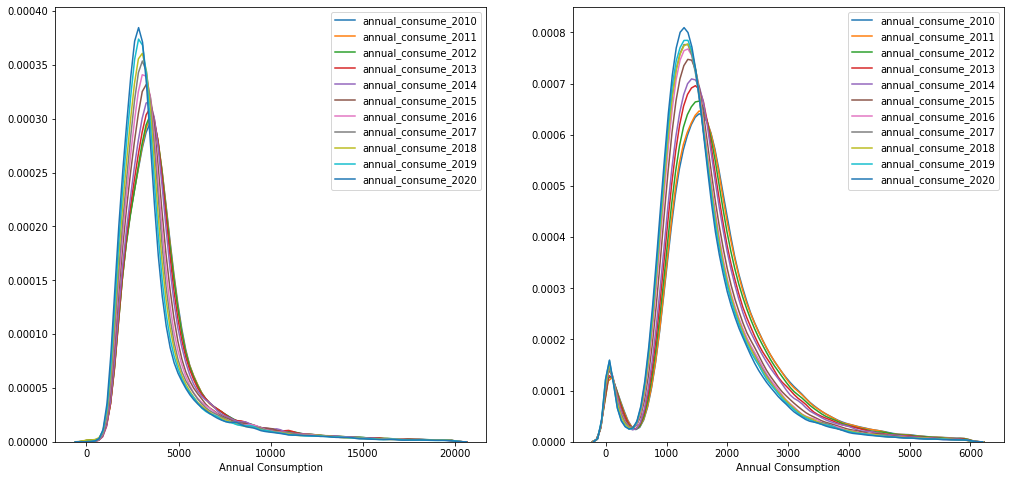

In [33]:
fig, ax = plt.subplots(1,2, figsize=(17,8))

for col in consume:
    sns.distplot(elec_full.loc[elec_full[col] < 20000, col], 
                 hist=False, label=col, ax=ax[0], axlabel='Annual Consumption')
    sns.distplot(gas_full.loc[gas_full[col] < 6000, col], 
                 hist=False, label=col, ax=ax[1], axlabel='Annual Consumption') 

plt.legend()

And the same can be done for the consumption per connection we created above

In [35]:
cons_per_conn = [col for col in gas_full.columns if 'consume_per_conn_' in col]
cons_per_conn.sort()

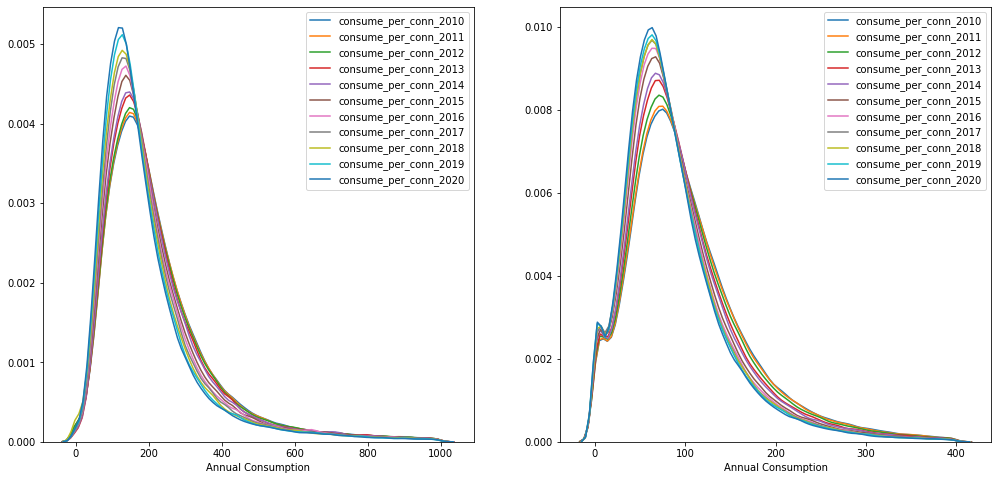

In [36]:
fig, ax = plt.subplots(1,2, figsize=(17,8))

for col in cons_per_conn:
    sns.distplot(elec_full.loc[elec_full[col] < 1000, col], 
                 hist=False, label=col, ax=ax[0], axlabel='Annual Consumption')
    sns.distplot(gas_full.loc[gas_full[col] < 400, col], 
                 hist=False, label=col, ax=ax[1],  axlabel='Annual Consumption')

plt.legend()

It appears to be very consistent every year, I wonder if we can observe that better (yes, it is pairplot time)

<Figure size 800x640 with 0 Axes>

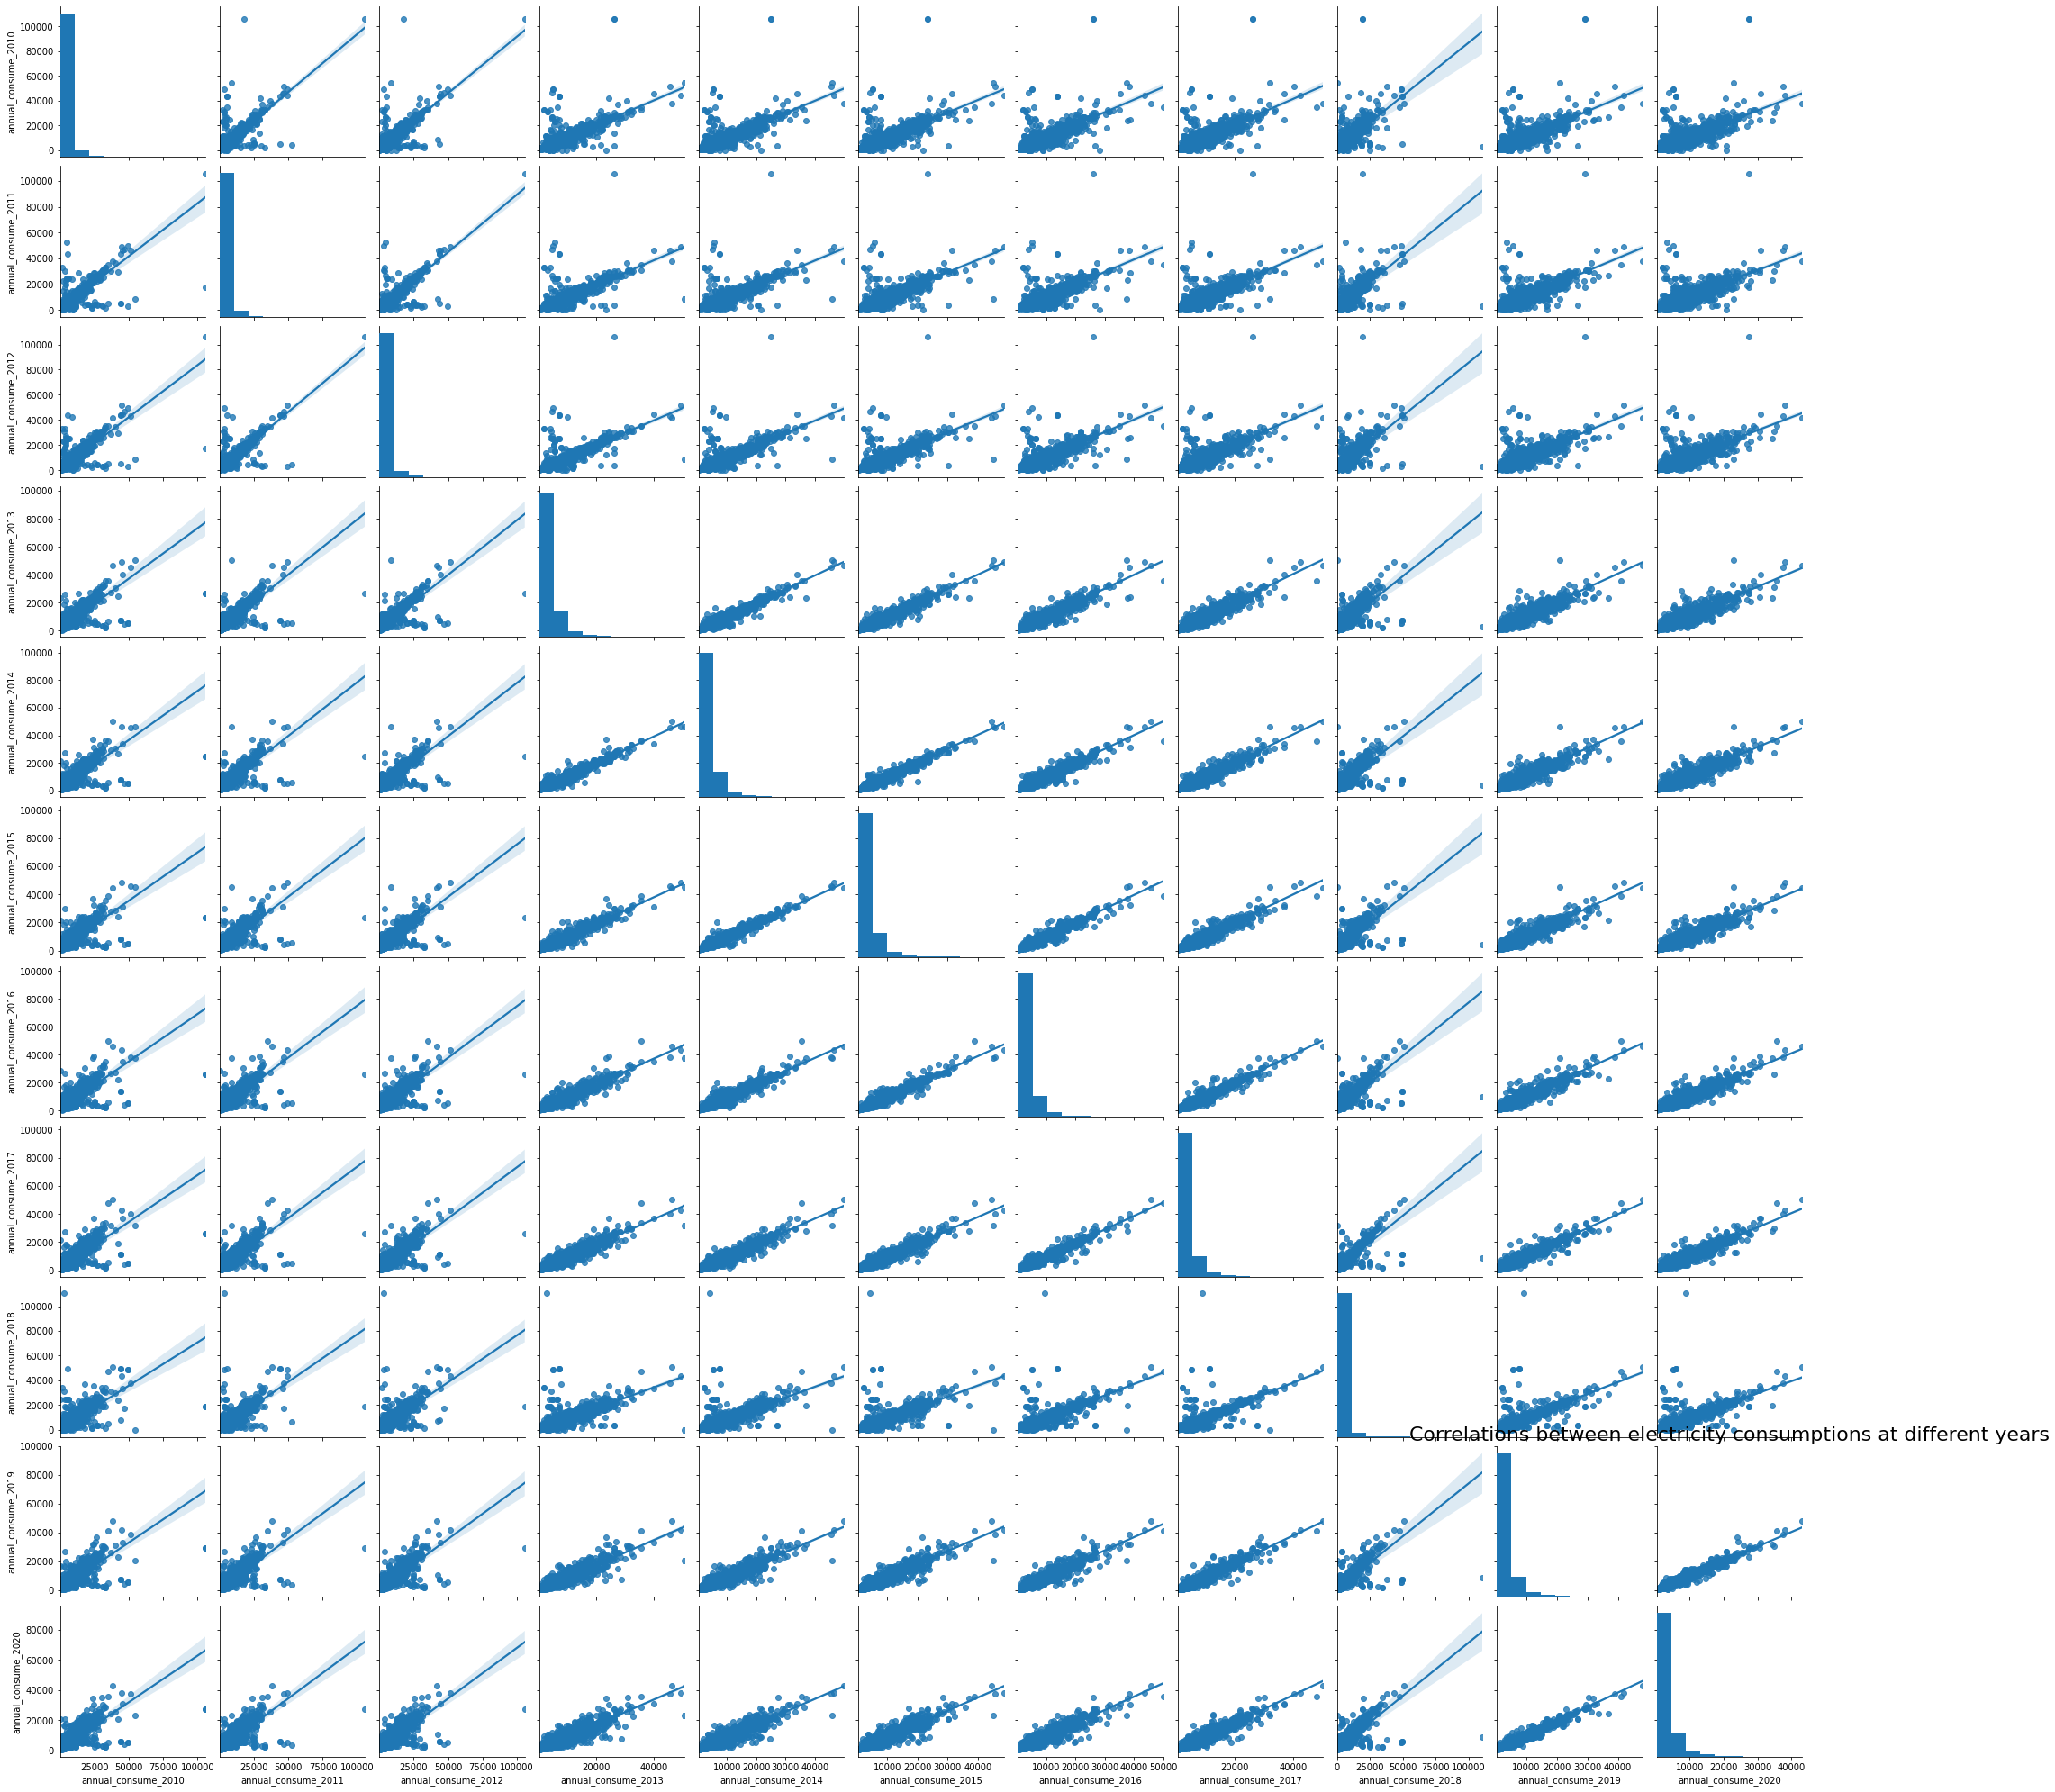

In [37]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(elec_full[consume].sample(10000), kind="reg")

plt.title('Correlations between electricity consumptions at different years', fontsize=22)

plt.show()

Yep, it is pretty consistent.

Next, we could focus on aggregating by city

In [38]:
elec_city = elec_full[['city', 'annual_consume_2010']].groupby('city', as_index=False).sum()

for col in consume:
    if col == 'annual_consume_2010':
        continue
    tmp = elec_full[['city', col]].groupby('city', as_index=False).sum()
    elec_city = pd.merge(elec_city, tmp, on='city')

elec_city = elec_city.set_index('city')
elec_city['mean_consume'] = elec_city.mean(axis=1)
elec_city.sample(5)

,annual_consume_2010,annual_consume_2011,annual_consume_2012,annual_consume_2013,annual_consume_2014,annual_consume_2015,annual_consume_2016,annual_consume_2017,annual_consume_2018,annual_consume_2019,annual_consume_2020,mean_consume
city,,,,,,,,,,,,
ROSSUM GLD,294338,307962,298376,285495,288513,280960,275810,259306,242702.00,234391.00,245369.00,273929.272727
OLDEHOLTPADE,107128,109307,108365,103681,105776,98917,100396,99226,97315.00,95766.00,97658.00,102139.545455
MILDAM,85650,84674,85928,79907,81577,78481,81044,79481,74508.00,67568.00,66503.00,78665.545455
LAUWERZIJL,15521,15530,16348,14076,12811,11842,12717,12695,13216.93,12515.76,11485.52,13523.473636
ZIJDERVELD,85742,85742,86865,89120,90146,85835,82264,80305,82880.00,79931.00,78883.29,84337.571818


Let's see the top 10 cities by electricity consumption

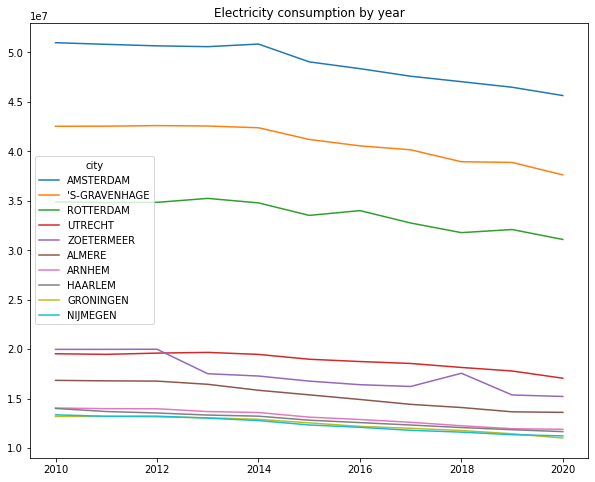

In [40]:
tmp = elec_city.nlargest(10, 'mean_consume')
del tmp['mean_consume'] # so it doesn't show up in the plot
tmp.columns = tmp.columns.str.replace('annual_consume_', '')
ax = tmp.T.plot(figsize=(10,8), title='Electricity consumption by year')
del tmp

Which is nice but it is just confirming that some cities are more populated than others. Let's do it again with consumption per connection

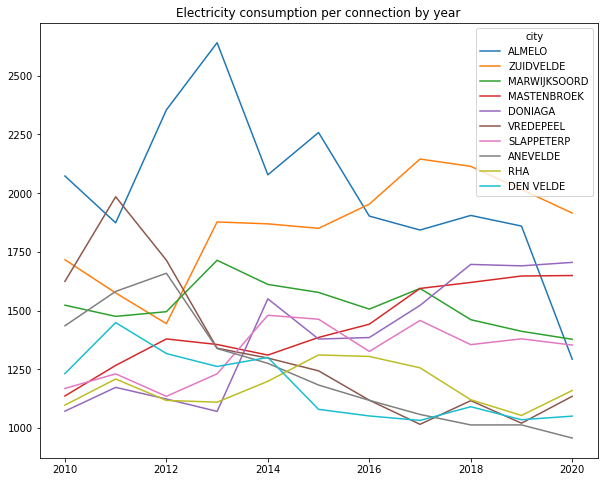

In [41]:
elec_city = elec_full[['city', 'annual_consume_2010', 'num_connections_2010']].groupby('city', as_index=False).sum()
elec_city['cons_per_con_2010'] = elec_city['annual_consume_2010'] / elec_city['num_connections_2010']
del elec_city['num_connections_2010']
del elec_city['annual_consume_2010']

for col in consume:
    if col == 'annual_consume_2010':
        continue
    yr = col.split('_')[-1]
    tmp = elec_full[['city', col, 'num_connections_'+yr]].groupby('city', as_index=False).sum()
    tmp['cons_per_con_'+yr] = tmp[col] / tmp['num_connections_'+yr]
    del tmp[col]
    del tmp['num_connections_'+yr]
    elec_city = pd.merge(elec_city, tmp, on='city')

elec_city = elec_city.set_index('city')
elec_city['mean_consume'] = elec_city.mean(axis=1)
tmp = elec_city.nlargest(10, 'mean_consume')
del tmp['mean_consume']
tmp.columns = tmp.columns.str.replace('cons_per_con_', '')
ax = tmp.T.plot(figsize=(10,8), title='Electricity consumption per connection by year')
#ax.set_xticklabels(['','2010','2011','2012', '2013','2014','2015','2016','2017','2018'])
del tmp

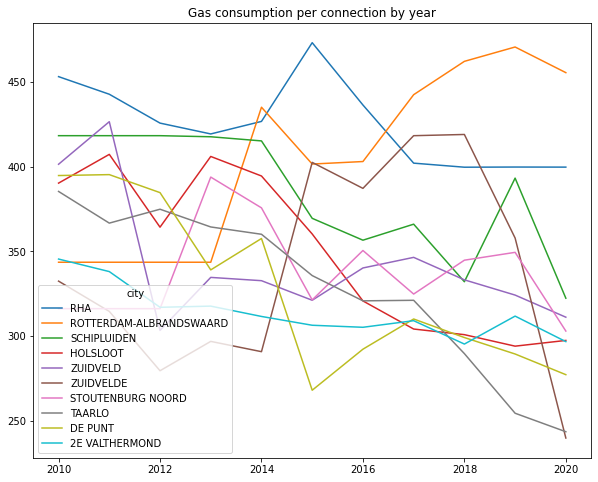

In [42]:
gas_city = gas_full[['city', 'annual_consume_2010', 'num_connections_2010']].groupby('city', as_index=False).sum()
gas_city['cons_per_con_2010'] = gas_city['annual_consume_2010'] / gas_city['num_connections_2010']
del gas_city['num_connections_2010']
del gas_city['annual_consume_2010']

for col in consume:
    if col == 'annual_consume_2010':
        continue
    yr = col.split('_')[-1]
    tmp = gas_full[['city', col, 'num_connections_'+yr]].groupby('city', as_index=False).sum()
    tmp['cons_per_con_'+yr] = tmp[col] / tmp['num_connections_'+yr]
    del tmp[col]
    del tmp['num_connections_'+yr]
    gas_city = pd.merge(gas_city, tmp, on='city')

gas_city = gas_city.set_index('city')
gas_city['mean_consume'] = gas_city.mean(axis=1)
tmp = gas_city.nlargest(10, 'mean_consume')
del tmp['mean_consume']
tmp.columns = tmp.columns.str.replace('cons_per_con_', '')
ax = tmp.T.plot(figsize=(10,8), title='Gas consumption per connection by year')
#ax.set_xticklabels(['','2010','2011','2012', '2013','2014','2015','2016','2017','2018'])
del tmp

In [43]:
print(elec_city.nlargest(10, 'mean_consume')['mean_consume'])
print('_'*40)
print(gas_city.nlargest(10, 'mean_consume')['mean_consume'])

city
ALMELO          2007.735674
ZUIDVELDE       1861.853197
MARWIJKSOORD    1523.000000
MASTENBROEK     1435.646032
DONIAGA         1397.537063
VREDEPEEL       1328.789899
SLAPPETERP      1325.955128
ANEVELDE        1239.824050
RHA             1176.781621
DEN VELDE       1173.303239
Name: mean_consume, dtype: float64
________________________________________
city
RHA                        425.304545
ROTTERDAM-ALBRANDSWAARD    404.046245
SCHIPLUIDEN                384.282645
HOLSLOOT                   349.013821
ZUIDVELD                   343.115333
ZUIDVELDE                  339.831713
STOUTENBURG NOORD          337.376446
TAARLO                     328.716562
DE PUNT                    327.883516
2E VALTHERMOND             313.938182
Name: mean_consume, dtype: float64


Not only this plot is very bad looking, but also somewhat misleading since we are aggregating by city a dataset that does not have all the data of every city (due to the merge). Let's free up some memory and do it in a better way and see if we still get what it appears to be a slightly negative trend.

# Aggregating data by city, the better way

In [44]:
del elec_full
del gas_full
del elec_city
del gas_city

gc.collect()

302339

This time, we aggregate the data *before* the merge.

In [91]:
def aggr_yr(data, yr):
    # useful features
    data['net_annual_cons_'+yr] = data['annual_consume'] * data['delivery_perc'] / 100
    data['self_production_'+yr] = data['annual_consume'] - data['net_annual_cons_'+yr]
    data['low_tarif_cons_'+yr] = data['annual_consume'] * data['annual_consume_lowtarif_perc'] / 100
    data['active_conn_'+yr] = data['num_connections'] * data['perc_of_active_connections'] / 100
    data['num_smartmeters_'+yr] = data['num_connections'] * data['smartmeter_perc'] / 100
    data = data.rename(columns={'annual_consume': 'annual_consume_'+yr})
    # aggregations
    aggregation = data[['city', 'annual_consume_'+yr, 'net_annual_cons_'+yr,
                        'self_production_'+yr, 'low_tarif_cons_'+yr,
                        'active_conn_'+yr, 'num_smartmeters_'+yr]].groupby('city', as_index=False).sum()
    return aggregation

def aggr_mng(data_dict):
    all_man = pd.DataFrame()
    for key in data_dict.keys():
        df = data_dict[key].copy()
        yr = key.split('_')[-1]
        if len(all_man) == 0:
            all_man = aggr_yr(df, yr)
        else:
            df = aggr_yr(df,yr)
            all_man = pd.merge(all_man, df, on='city')
        del df
        gc.collect()
    all_man = all_man.set_index('city')
    return all_man

def aggregations(data_dict):
    result = pd.DataFrame()
    for manager in ['enexis', 'liander', 'stedin']:
        print(manager)
        tmp = { key: data_dict[key] for key in data_dict.keys() if manager in key}
        all_man = aggr_mng(tmp)
        if len(result) == 0:
            result = all_man.copy()
        else:
            result = pd.concat([result, all_man], join='inner')
        del all_man
        gc.collect()
        print("_"*40)
    print(f"Final shape: {result.shape}")
    return result

In [94]:
cities_el = aggregations(imp_elec)
cities_el.sample(10)

enexis
________________________________________
liander
________________________________________
stedin
________________________________________
Final shape: (2304, 66)


,annual_consume_2014,net_annual_cons_2014,self_production_2014,low_tarif_cons_2014,active_conn_2014,num_smartmeters_2014,annual_consume_2017,net_annual_cons_2017,self_production_2017,low_tarif_cons_2017,...,self_production_2010,low_tarif_cons_2010,active_conn_2010,num_smartmeters_2010,annual_consume_2019,net_annual_cons_2019,self_production_2019,low_tarif_cons_2019,active_conn_2019,num_smartmeters_2019
city,,,,,,,,,,,,,,,,,,,,,
HEUMEN,206410,2.013591e+05,5050.8984,1.022615e+05,733.0049,43.9987,199175,1.878057e+05,11369.2925,1.108730e+05,...,0.0000,8.812731e+04,715.0001,2.0008,202431.00,1.794988e+05,22932.175500,1.553388e+05,811.9962,627.9929
NIEUWERBRUG AAN DEN RIJN,199680,1.947671e+05,4912.9375,1.823015e+05,757.0008,63.0037,191203,1.816149e+05,9588.1414,1.737991e+05,...,3091.0768,2.038828e+05,763.9038,26.0474,208260.00,1.857877e+05,22472.282900,1.949218e+05,794.0000,268.9977
TIEL,3936879,3.875608e+06,61271.3724,1.946761e+06,17997.9744,1066.9925,3654958,3.482832e+06,172126.3083,2.020016e+06,...,2229.3341,1.576034e+06,17389.9845,2.0004,3524129.00,3.254785e+06,269344.278400,2.675905e+06,18347.9751,11848.0264
OENE,318532,2.951016e+05,23430.3599,1.643003e+05,682.9991,79.9997,314598,2.812818e+05,33316.2265,1.738934e+05,...,0.0000,1.502307e+05,648.0016,2.0013,309835.00,2.673752e+05,42459.842300,1.766128e+05,726.9974,229.0020
RHEEZERVEEN,64309,6.177265e+04,2536.3500,2.809789e+04,283.0000,27.2600,60142,5.510173e+04,5040.2700,2.591183e+04,...,0.0000,2.937379e+04,280.0000,0.0000,75695.97,6.702510e+04,8670.868047,3.327916e+04,275.0000,91.9960
HORN,382297,3.685417e+05,13755.3100,1.929163e+05,1592.0000,215.1000,353616,3.250848e+05,28531.2500,1.801560e+05,...,0.0000,1.848938e+05,1466.0000,0.0000,378920.05,3.246683e+05,54251.725041,1.935441e+05,1651.0000,512.0077
OUDESCHIP,29209,2.796616e+04,1242.8400,9.792510e+03,147.0000,7.2500,28705,2.399887e+04,4706.1300,1.055805e+04,...,0.0000,9.665090e+03,139.0000,0.0000,34676.18,2.870770e+04,5968.479665,1.603423e+04,127.0000,79.0003
BLAUWHUIS,62929,5.879108e+04,4137.9191,2.346631e+04,237.0004,17.0010,57001,5.020132e+04,6799.6796,2.935600e+04,...,0.0000,1.362273e+04,242.0022,0.0000,53865.00,4.573358e+04,8131.416600,3.487490e+04,236.0014,118.0015
RHOON,1112380,1.094735e+06,17644.5462,1.014755e+06,6753.0037,1322.0106,1077264,1.039989e+06,37275.2058,9.950321e+05,...,6441.2473,1.010530e+06,6607.0037,1023.0017,1002885.00,9.367440e+05,66140.972600,9.772810e+05,6899.0000,5701.9870


In [95]:
cities_el.describe()

,annual_consume_2014,net_annual_cons_2014,self_production_2014,low_tarif_cons_2014,active_conn_2014,num_smartmeters_2014,annual_consume_2017,net_annual_cons_2017,self_production_2017,low_tarif_cons_2017,...,self_production_2010,low_tarif_cons_2010,active_conn_2010,num_smartmeters_2010,annual_consume_2019,net_annual_cons_2019,self_production_2019,low_tarif_cons_2019,active_conn_2019,num_smartmeters_2019
count,2.304000e+03,2.304000e+03,2304.000000,2.304000e+03,2304.000000,2304.000000,2.304000e+03,2.304000e+03,2.304000e+03,2.304000e+03,...,2304.000000,2.304000e+03,2304.000000,2304.000000,2.304000e+03,2.304000e+03,2.304000e+03,2.304000e+03,2304.000000,2304.000000
mean,6.553212e+05,6.385842e+05,16736.998480,3.271004e+05,3199.067143,321.850117,6.278523e+05,5.919786e+05,3.587370e+04,3.550706e+05,...,1403.893236,3.063067e+05,3085.567794,72.391329,6.314710e+05,5.712503e+05,5.980133e+04,4.075604e+05,3391.172348,2132.281705
std,2.196483e+06,2.168774e+06,34026.308487,1.192701e+06,14212.249440,1778.724401,2.148155e+06,2.090175e+06,7.168150e+04,1.286258e+06,...,8635.330903,1.129953e+06,13866.336655,749.900256,2.099902e+06,2.002814e+06,1.187839e+05,1.471662e+06,15245.806570,9952.444158
min,2.583000e+03,2.583000e+03,0.000000,2.066400e+02,0.000000,0.000000,2.540000e+03,1.512460e+03,0.000000e+00,6.053886e+02,...,0.000000,2.095200e+02,0.000000,0.000000,2.420000e+03,1.990638e+03,0.000000e+00,6.661060e+02,0.000000,0.000000
25%,6.201050e+04,5.896440e+04,2768.295775,2.925562e+04,200.999900,14.002000,5.854450e+04,5.132953e+04,5.766678e+03,2.962218e+04,...,0.000000,2.511430e+04,202.750000,0.000000,6.426255e+04,5.392692e+04,9.301199e+03,3.578048e+04,208.001500,89.996850
50%,1.707550e+05,1.640167e+05,6874.143100,7.937255e+04,638.001950,46.031950,1.622275e+05,1.469980e+05,1.425660e+04,8.414471e+04,...,122.382600,7.473709e+04,614.000200,0.000000,1.726974e+05,1.469460e+05,2.361236e+04,1.002783e+05,651.000000,314.003750
75%,4.869800e+05,4.728989e+05,16755.918125,2.317106e+05,1956.002475,173.258950,4.624105e+05,4.284697e+05,3.556668e+04,2.418364e+05,...,702.385000,2.150160e+05,1889.253225,1.020000,4.717288e+05,4.069727e+05,5.829899e+04,2.838251e+05,2025.748275,1159.745250
max,5.509295e+07,5.474099e+07,508933.589900,3.192955e+07,414200.287100,66136.054400,5.543872e+07,5.475181e+07,1.025410e+06,3.155625e+07,...,292910.121800,3.173078e+07,408548.289700,20538.045500,5.483659e+07,5.377192e+07,1.759435e+06,3.350962e+07,459621.439200,297239.376600


In [96]:
cities_gas = aggregations(imp_gas)
cities_gas.sample(10)

enexis
________________________________________
liander
________________________________________
stedin
________________________________________
Final shape: (1651, 66)


,annual_consume_2015,net_annual_cons_2015,self_production_2015,low_tarif_cons_2015,active_conn_2015,num_smartmeters_2015,annual_consume_2017,net_annual_cons_2017,self_production_2017,low_tarif_cons_2017,...,self_production_2011,low_tarif_cons_2011,active_conn_2011,num_smartmeters_2011,annual_consume_2018,net_annual_cons_2018,self_production_2018,low_tarif_cons_2018,active_conn_2018,num_smartmeters_2018
city,,,,,,,,,,,,,,,,,,,,,
GORSSEL,189959,189959.0,0.0,0.0,1888.9996,234.9985,186697,186697.0,0.0,0.0,...,0.0,0.0,1783.0027,0.0000,185494.00,185494.00,0.0,0.0,1922.9986,449.9860
KROMMENIE,633000,633000.0,0.0,0.0,7886.9976,416.0015,605951,605951.0,0.0,0.0,...,0.0,0.0,7758.0021,3.0010,606950.00,606950.00,0.0,0.0,7895.9967,1259.0037
HOOGBLOKLAND,59759,59759.0,0.0,0.0,577.0012,55.0051,55176,55176.0,0.0,0.0,...,0.0,0.0,574.0010,1.0010,55307.00,55307.00,0.0,0.0,579.0006,159.9993
VUGHT,2271,2271.0,0.0,0.0,19.0000,0.0000,928297,928297.0,0.0,0.0,...,0.0,0.0,28.0000,0.0000,1008581.02,1008581.02,0.0,0.0,10707.0000,0.0000
BUITENPOST,270023,270023.0,0.0,0.0,2545.9969,84.9999,266002,266002.0,0.0,0.0,...,0.0,0.0,2527.9963,2.0004,259697.00,259697.00,0.0,0.0,2549.0056,402.9960
POEDEROIJEN,35544,35544.0,0.0,0.0,343.9998,51.0013,34514,34514.0,0.0,0.0,...,0.0,0.0,307.9985,0.0000,36456.00,36456.00,0.0,0.0,350.0008,94.9997
ZALTBOMMEL,477046,477046.0,0.0,0.0,5421.9939,663.0088,463171,463171.0,0.0,0.0,...,0.0,0.0,5197.9947,4.0022,477154.00,477154.00,0.0,0.0,5673.0009,1797.9908
HOOGLAND,355633,355633.0,0.0,0.0,4273.9994,416.9970,346436,346436.0,0.0,0.0,...,0.0,0.0,4216.9961,68.9951,344339.00,344339.00,0.0,0.0,4270.9985,3513.0026
BUURMALSEN,42244,42244.0,0.0,0.0,392.9996,28.9964,40014,40014.0,0.0,0.0,...,0.0,0.0,390.9995,0.0000,39553.00,39553.00,0.0,0.0,391.9984,67.9949


In [97]:
cities_gas.describe()

,annual_consume_2015,net_annual_cons_2015,self_production_2015,low_tarif_cons_2015,active_conn_2015,num_smartmeters_2015,annual_consume_2017,net_annual_cons_2017,self_production_2017,low_tarif_cons_2017,...,self_production_2011,low_tarif_cons_2011,active_conn_2011,num_smartmeters_2011,annual_consume_2018,net_annual_cons_2018,self_production_2018,low_tarif_cons_2018,active_conn_2018,num_smartmeters_2018
count,1.651000e+03,1.651000e+03,1651.000000,1651.0,1651.000000,1651.000000,1.651000e+03,1.651000e+03,1651.000000,1651.000000,...,1651.000000,1651.0,1651.000000,1651.000000,1.651000e+03,1.651000e+03,1651.000000,1651.0,1651.000000,1651.000000
mean,2.834906e+05,2.834892e+05,1.447002,0.0,3524.633104,310.391886,2.765866e+05,2.765866e+05,0.039692,45.379891,...,0.015354,0.0,3392.716910,74.753491,2.871189e+05,2.871188e+05,0.081430,0.0,3614.734643,1099.881710
std,8.811121e+05,8.811104e+05,48.678495,0.0,13807.657810,1858.378803,8.707672e+05,8.707672e+05,1.392863,1843.898389,...,0.623885,0.0,13615.907437,731.923337,8.846952e+05,8.846951e+05,3.308709,0.0,14346.919256,6387.869251
min,1.347000e+03,1.347000e+03,0.000000,0.0,6.999600,0.000000,1.091000e+03,1.091000e+03,0.000000,0.000000,...,0.000000,0.0,8.000900,0.000000,1.092000e+03,1.092000e+03,0.000000,0.0,6.999600,0.000000
25%,2.855650e+04,2.855650e+04,0.000000,0.0,244.000900,0.000000,2.799850e+04,2.799850e+04,0.000000,0.000000,...,0.000000,0.0,233.999800,0.000000,3.054670e+04,3.054670e+04,0.000000,0.0,254.997600,0.000000
50%,7.718000e+04,7.718000e+04,0.000000,0.0,728.000000,10.999000,7.591600e+04,7.591600e+04,0.000000,0.000000,...,0.000000,0.0,683.999900,0.000000,8.035045e+04,8.035045e+04,0.000000,0.0,751.000000,39.005800
75%,2.203940e+05,2.203940e+05,0.000000,0.0,2286.501100,117.503400,2.138100e+05,2.138100e+05,0.000000,0.000000,...,0.000000,0.0,2193.500150,1.999600,2.257310e+05,2.257310e+05,0.000000,0.0,2345.000000,398.499050
max,1.904275e+07,1.904275e+07,1966.812500,0.0,350515.090800,62086.124400,1.984082e+07,1.984082e+07,55.749800,74922.200000,...,25.350000,0.0,348568.001700,20480.028900,1.986685e+07,1.986685e+07,134.441100,0.0,379546.016500,181085.221100


## Energy consumption

Let's have a look at the total energy consumption of the country.

In [98]:
consume = [col for col in cities_el.columns if 'annual_consume_' in col]
consume.sort()

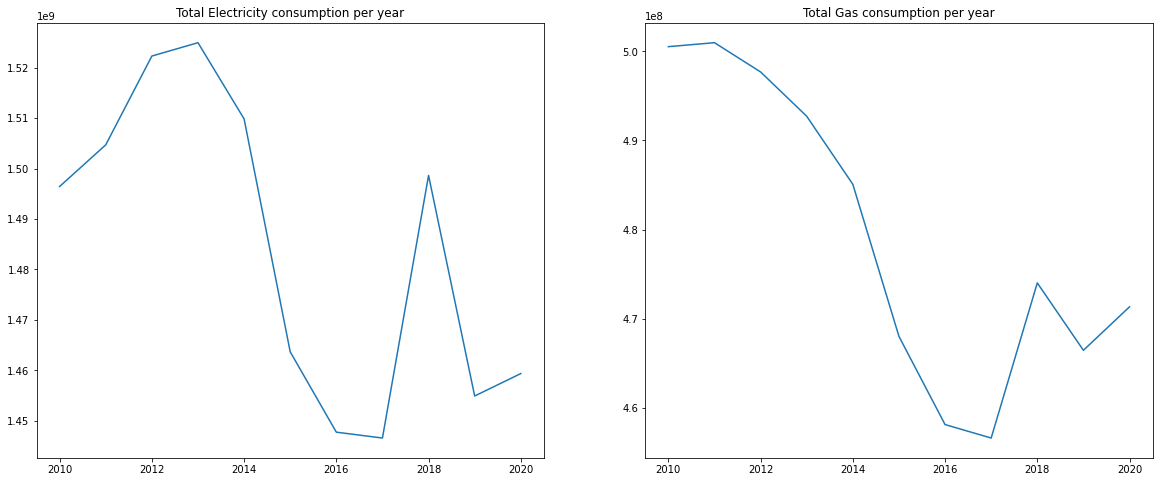

In [100]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))

cities_el[consume].sum().plot(title='Total Electricity consumption per year', ax=ax[0])
ax[0].set_xticklabels(['','2010','2012','2014','2016','2018','2020'])
cities_gas[consume].sum().plot(title='Total Gas consumption per year', ax=ax[1])
ax[1].set_xticklabels(['','2010','2012','2014','2016','2018','2020'])

plt.show()

We indeed observe a descending trend, with something odd happening in 2018. **This can very well be a mistake during the data cleaning or data preparation.**

Again, focusing on cities with high consumption will just lead to the most populated cities.

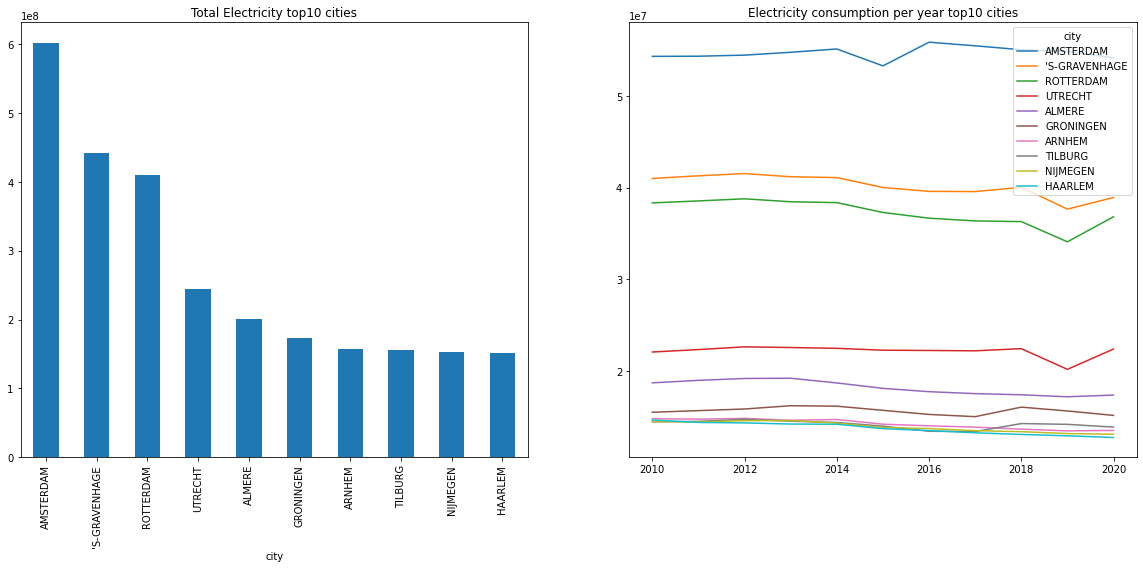

In [101]:
tmp = cities_el[consume].copy()
tmp['mean_consume'] = tmp.mean(axis=1)
tmp = tmp.nlargest(10, 'mean_consume')
del tmp['mean_consume']
tmp.columns = tmp.columns.str.replace('annual_consume_', '')

fig, ax = plt.subplots(1,2, figsize=(20, 8))
tmp.T.sum().plot(kind='bar', title='Total Electricity top10 cities', ax=ax[0])
tmp.T.plot(title='Electricity consumption per year top10 cities',ax=ax[1])
ax[1].set_xticklabels(['','2010','2012','2014','2016','2018','2020'])

plt.show()

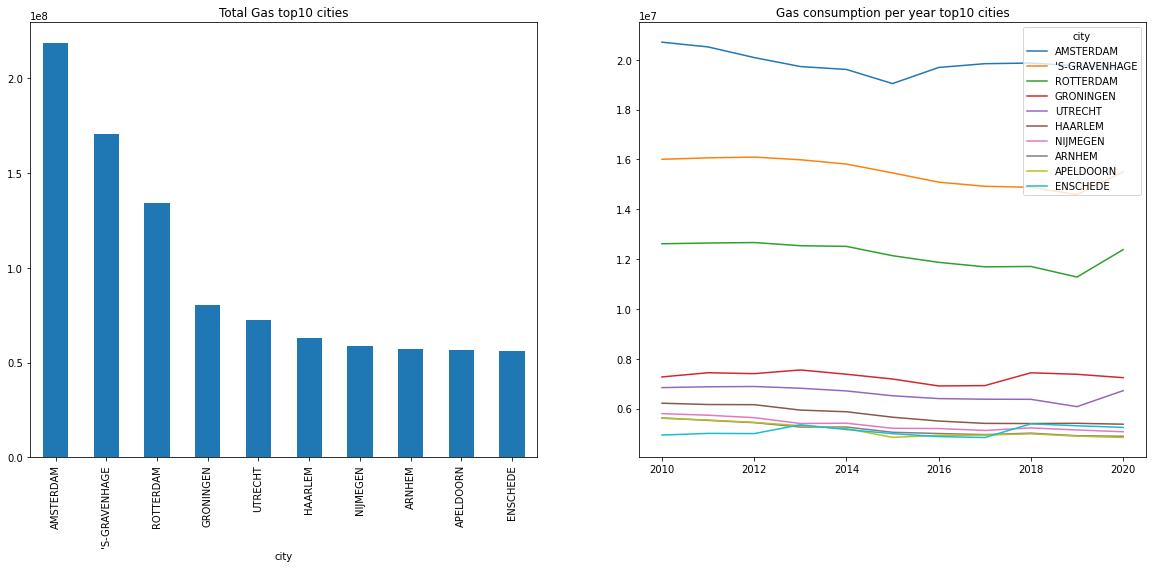

In [102]:
tmp = cities_gas[consume].copy()
tmp['mean_consume'] = tmp.mean(axis=1)
tmp = tmp.nlargest(10, 'mean_consume')
del tmp['mean_consume']
tmp.columns = tmp.columns.str.replace('annual_consume_', '')

fig, ax = plt.subplots(1,2, figsize=(20, 8))
tmp.T.sum().plot(kind='bar', title='Total Gas top10 cities', ax=ax[0])
tmp.T.plot(title='Gas consumption per year top10 cities',ax=ax[1])
ax[1].set_xticklabels(['','2010','2012','2014','2016','2018','2020'])
plt.show()

## Self-production

Let's see if we can identify some trend in the energy produced by the population (most likely solar panels, for which there have been some incentives given by the government)

In [103]:
self_prod = [col for col in cities_el.columns if 'self_production_' in col]
self_prod.sort()

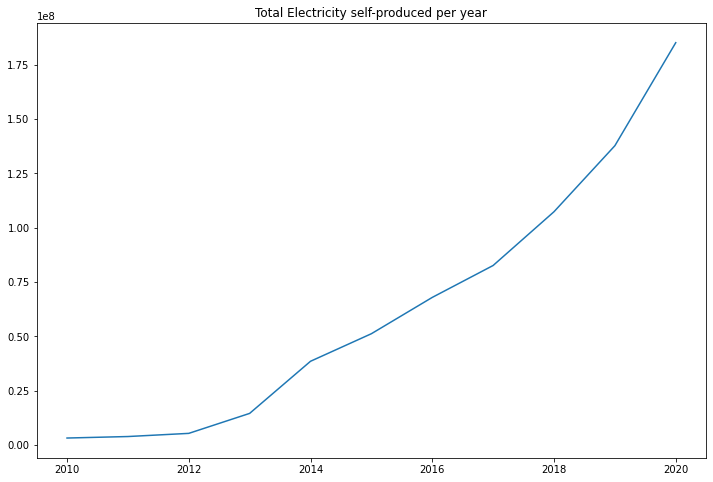

In [104]:
ax = cities_el[self_prod].sum().plot(figsize=(12, 8),title='Total Electricity self-produced per year')
ax.set_xticklabels(['','2010','2012','2014','2016','2018','2020'])

plt.show()

If we define the top cities as the one that had the maximum production at some point in the period under analysis, we get some **Almere pride** in the air

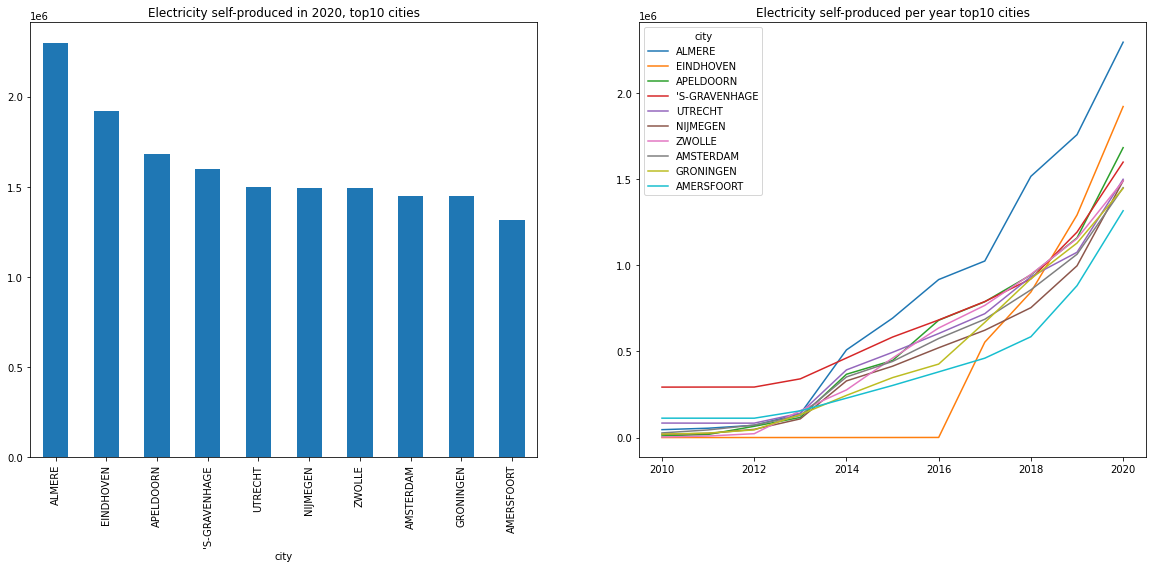

In [106]:
tmp = cities_el[self_prod].copy()
tmp['max_prod'] = tmp.max(axis=1)
tmp = tmp.nlargest(10, 'max_prod')
del tmp['max_prod']
tmp.columns = tmp.columns.str.replace('self_production_', '')

fig, ax = plt.subplots(1,2, figsize=(20, 8))
tmp['2020'].T.plot(kind='bar', title='Electricity self-produced in 2020, top10 cities', ax=ax[0])
tmp.T.plot(title='Electricity self-produced per year top10 cities',ax=ax[1])
ax[1].set_xticklabels(['','2010','2012','2014','2016','2018','2020'])
plt.show()

## Smart meters

In [108]:
smrt = [col for col in cities_el.columns if 'num_smartmeters_' in col]
smrt.sort()

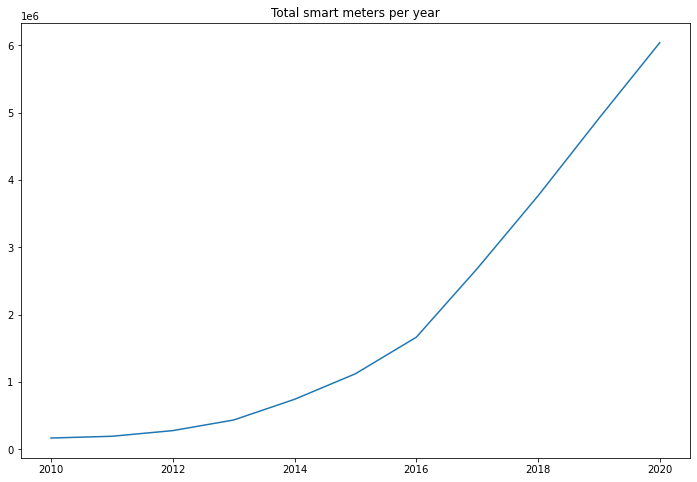

In [109]:
ax = cities_el[smrt].sum().plot(figsize=(12, 8),title='Total smart meters per year')
ax.set_xticklabels(['','2010','2012','2014','2016','2018','2020'])

plt.show()

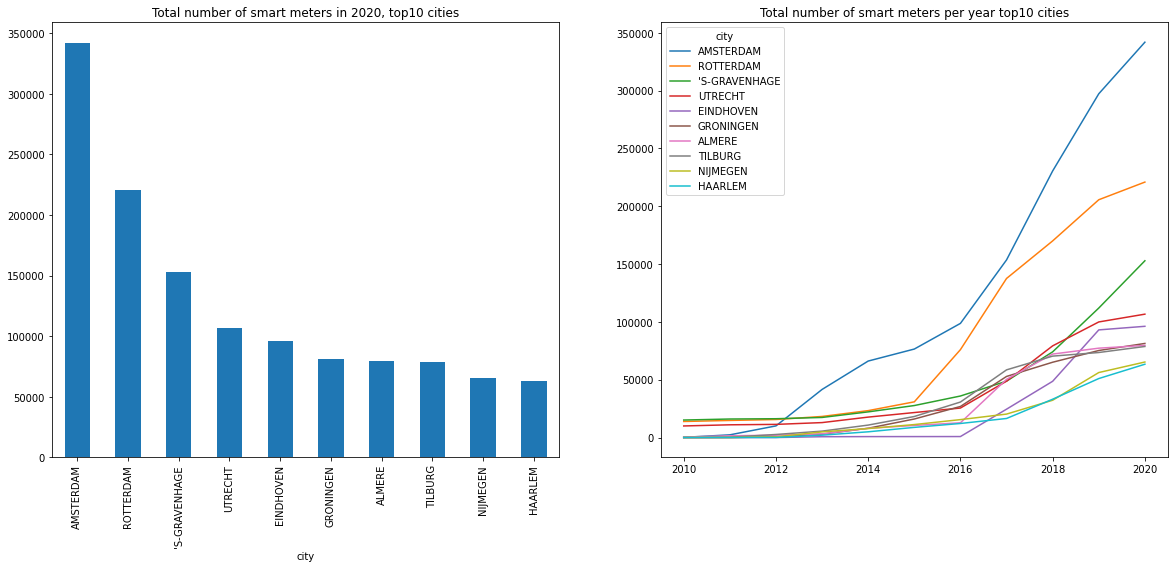

In [110]:
tmp = cities_el[smrt].copy()
tmp['max_num'] = tmp.max(axis=1)
tmp = tmp.nlargest(10, 'max_num')
del tmp['max_num']
tmp.columns = tmp.columns.str.replace('num_smartmeters_', '')

fig, ax = plt.subplots(1,2, figsize=(20, 8))
tmp['2020'].T.plot(kind='bar', title='Total number of smart meters in 2020, top10 cities', ax=ax[0])
tmp.T.plot(title='Total number of smart meters per year top10 cities',ax=ax[1])
ax[1].set_xticklabels(['','2010','2012','2014','2016','2018','2020'])
plt.show()

While it was predictable to find Amsterdam and Rotterdam leading this chart (being the biggest cities), it is interesting to notice that they grew similarly even though their networks are managed by different companies (Liander and Stedin, respectively)

# Conclusions

I hope this kernel gave you some inspiration on how to use this dataset, please share your thoughts about it, use it, find problems in the data and help me fix them :)

On a more personal note, I am not used (as you see) to making visualizations so every feedback will be very much appreciated.

Cheers.